In [1]:
import pandas as pd, numpy as np

trip_sheet = '/DATA/TripAnalysis/nextbike_trips.csv'

#before cleaning
trip_df = pd.read_csv(trip_sheet.lstrip('/'))
print(trip_df.head(5).to_string(index=False))
print(f"Length of the dataframe before cleaning: {len(trip_df)}")

trip_df = (
    pd.read_csv(trip_sheet.lstrip('/'))
      .pipe(lambda d: d.rename(columns={c: c.strip() for c in d.columns}))
      .assign(**{
          'Duration-Minutes': lambda d: pd.to_numeric(d['Duration-Minutes'], errors='coerce'),
          'Rental-Lat':       lambda d: pd.to_numeric(d['Rental-Lat'], errors='coerce'),
          'Rental-Lng':       lambda d: pd.to_numeric(d['Rental-Lng'], errors='coerce'),
          'Return-Lat':       lambda d: pd.to_numeric(d['Return-Lat'], errors='coerce'),
          'Return-Lng':       lambda d: pd.to_numeric(d['Return-Lng'], errors='coerce'),
      })
      .loc[lambda d: ~d.apply(lambda r: r.astype(str).str.contains('unbekannt', case=False).any(), axis=1)]
      .loc[lambda d: d['Duration-Minutes'] > 2]
      .loc[lambda d: ~((d['Rental-Lat'] == d['Return-Lat']) & (d['Rental-Lng'] == d['Return-Lng']))]
      .assign(**{
          'Rental-Time': lambda d: pd.to_datetime(d['Rental-Time'], errors='coerce'),
          'weekday_idx': lambda d: d['Rental-Time'].dt.weekday,
          'is_weekend':  lambda d: d['weekday_idx'] >= 5,
          'hour':        lambda d: d['Rental-Time'].dt.hour,
      })
      .reset_index(drop=True)
)

print(trip_df.head(5).to_string(index=False))
print(f"Length of the dataframe after cleaning: {len(trip_df)}")


 Bike-Number         Rental-Time        Rental-Type                                     Rental-Location  Rental-Lat  Rental-Lng         Return-Time        Return-Type                  Return-Location  Return-Lat  Return-Lng  Duration-Minutes   Movement-Type
      100245 2025-07-23 21:56:39 Station (virtuell)                            U Schlesisches Tor (Ost)   52.500794   13.442182 2025-07-23 22:08:17 Station (virtuell)        Elsenstraße/Harzer Straße   52.485136   13.449063              11.6 Station:Station
       13167 2025-07-23 20:22:59 Station (virtuell)                           Elsenstraße/Harzer Straße   52.485136   13.449063 2025-07-23 22:08:17 Station (virtuell) Modersohnstraße (Am Rudolfplatz)   52.502492   13.456503             105.3 Station:Station
       19766 2025-07-23 21:56:31 Station (physisch) Jelbi S+U Zoologischer Garten/Jebensstraße (CHA/JE)   52.506622   13.331480 2025-07-23 22:08:26 Station (virtuell)  Franklinstraße/Glutenbergstraße   52.518675   13.326239   

Trips loaded: 167799
Loaded 16 Flexzone Polygone


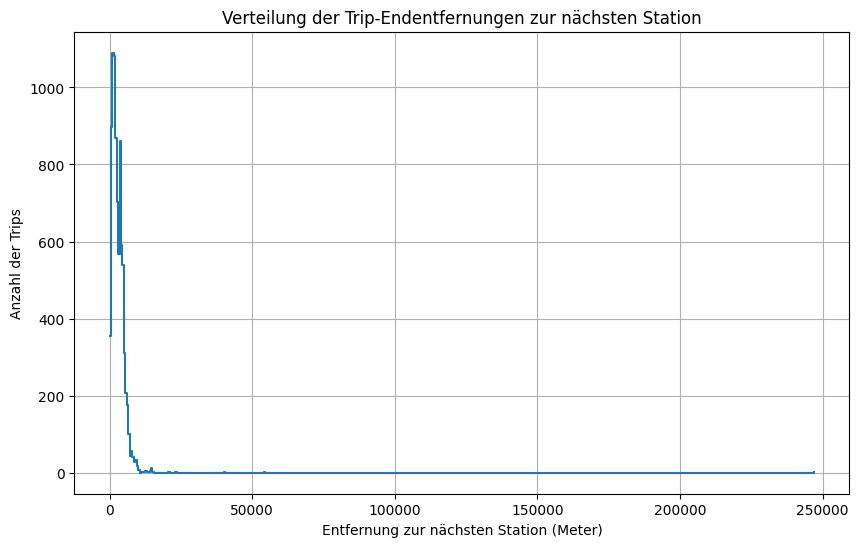

In [2]:
import pandas as pd
import numpy as np
import requests
from shapely.geometry import Point, Polygon
from geopy.distance import geodesic
import matplotlib.pyplot as plt

# 1. CSV mit Trips laden und bereinigen
trip_sheet = '/DATA/TripAnalysis/nextbike_trips.csv'

trip_df = (
    pd.read_csv(trip_sheet.lstrip('/'))
    .pipe(lambda d: d.rename(columns={c: c.strip() for c in d.columns}))
    .assign(**{
        'Duration-Minutes': lambda d: pd.to_numeric(d['Duration-Minutes'], errors='coerce'),
        'Rental-Lat': lambda d: pd.to_numeric(d['Rental-Lat'], errors='coerce'),
        'Rental-Lng': lambda d: pd.to_numeric(d['Rental-Lng'], errors='coerce'),
        'Return-Lat': lambda d: pd.to_numeric(d['Return-Lat'], errors='coerce'),
        'Return-Lng': lambda d: pd.to_numeric(d['Return-Lng'], errors='coerce'),
    })
    .loc[lambda d: ~d.apply(lambda r: r.astype(str).str.contains('unbekannt', case=False).any(), axis=1)]
    .loc[lambda d: d['Duration-Minutes'] > 2]
    .loc[lambda d: ~((d['Rental-Lat'] == d['Return-Lat']) & (d['Rental-Lng'] == d['Return-Lng']))]
    .reset_index(drop=True)
)

print(f"Trips loaded: {len(trip_df)}")

# 2. Flexzonen per URL laden (GeoJSON)
flexzone_url = "https://api.nextbike.net/reservation/geojson/flexzone_bn.json"
response = requests.get(flexzone_url)
data = response.json()

flex_polygons = []
for feature in data.get('features', []):
    if feature['geometry']['type'] == 'Polygon':
        coords = feature['geometry']['coordinates'][0]
        poly = Polygon([(c[0], c[1]) for c in coords])
        flex_polygons.append(poly)

print(f"Loaded {len(flex_polygons)} Flexzone Polygone")

# 3. Stationen manuell definieren (Beispiel: Liste mit (lat, lng))
# Da wir keine JSON mit Stationen laden, hier ein Beispiel mit fiktiven Stationen
# Du musst diese Liste mit echten Station-Koordinaten füllen, z.B. aus CSV oder API
station_positions = [
    (52.500794, 13.442182),  # Beispielstation 1
    (52.485136, 13.449063),  # Beispielstation 2
    (52.502492, 13.456503),  # Beispielstation 3
    (52.506622, 13.331480),  # Beispielstation 4
    # ... weitere Stationen ...
]

# 4. Distanzfunktionen definieren
def distance_to_nearest_station(lat, lng):
    min_dist = float('inf')
    for s_lat, s_lng in station_positions:
        dist = geodesic((lat, lng), (s_lat, s_lng)).meters
        if dist < min_dist:
            min_dist = dist
    return min_dist

def distance_to_nearest_flexzone(lat, lng):
    point = Point(lng, lat)
    min_dist = float('inf')
    for poly in flex_polygons:
        centroid = poly.centroid
        dist = geodesic((lat, lng), (centroid.y, centroid.x)).meters
        if dist < min_dist:
            min_dist = dist
    return min_dist

def is_flexzone(loc):
    return loc == "Flexzone"

def is_noflexzone(loc):
    return loc == "außerhalb Flexzone"

# 5. Distanzen berechnen und ins DataFrame schreiben
trip_df['dist_to_station_m'] = np.nan
trip_df['dist_to_flexzone_m'] = np.nan

for idx, row in trip_df.iterrows():
    ret_loc = row['Return-Location']
    ret_lat = row['Return-Lat']
    ret_lng = row['Return-Lng']
    if pd.isna(ret_lat) or pd.isna(ret_lng):
        continue
    if is_flexzone(ret_loc):
        trip_df.at[idx, 'dist_to_station_m'] = distance_to_nearest_station(ret_lat, ret_lng)
    elif is_noflexzone(ret_loc):
        trip_df.at[idx, 'dist_to_station_m'] = distance_to_nearest_station(ret_lat, ret_lng)
        trip_df.at[idx, 'dist_to_flexzone_m'] = distance_to_nearest_flexzone(ret_lat, ret_lng)

# 6. Ergebnis visualisieren (Linien-Diagramm der Entfernungen zur Station)
distances = trip_df['dist_to_station_m'].dropna()

bins = np.arange(0, distances.max() + 500, 500)
hist, bin_edges = np.histogram(distances, bins=bins)

plt.figure(figsize=(10,6))
plt.plot(bin_edges[:-1], hist, drawstyle='steps-post')
plt.xlabel('Entfernung zur nächsten Station (Meter)')
plt.ylabel('Anzahl der Trips')
plt.title('Verteilung der Trip-Endentfernungen zur nächsten Station')
plt.grid(True)
plt.show()


In [17]:
import pandas as pd
import numpy as np
import requests
from scipy.spatial import KDTree
import sys
import time

# --- 1. Nextbike API für Berlin abrufen und Stationen mit bike: false extrahieren ---

API_URL = "https://api.nextbike.net/maps/nextbike-live.json?city=362"
response = requests.get(API_URL)
data = response.json()

stations_bike_false = []

for country in data.get('countries', []):
    for city in country.get('cities', []):
        if city.get('uid') == 362:
            for place in city.get('places', []):
                if place.get('spot', False) and place.get('bike', True) == False:
                    lat = place.get('lat')
                    lng = place.get('lng')
                    if lat is not None and lng is not None:
                        stations_bike_false.append((lat, lng))

print(f"Gefundene Stationen mit bike: false: {len(stations_bike_false)}")

# --- 2. Trip-CSV laden und bereinigen ---

trip_sheet = '/DATA/TripAnalysis/nextbike_trips.csv'

trip_df = (
    pd.read_csv(trip_sheet.lstrip('/'))
    .pipe(lambda d: d.rename(columns={c: c.strip() for c in d.columns}))
    .assign(**{
        'Duration-Minutes': lambda d: pd.to_numeric(d['Duration-Minutes'], errors='coerce'),
        'Rental-Lat': lambda d: pd.to_numeric(d['Rental-Lat'], errors='coerce'),
        'Rental-Lng': lambda d: pd.to_numeric(d['Rental-Lng'], errors='coerce'),
        'Return-Lat': lambda d: pd.to_numeric(d['Return-Lat'], errors='coerce'),
        'Return-Lng': lambda d: pd.to_numeric(d['Return-Lng'], errors='coerce'),
    })
    .loc[lambda d: ~d.apply(lambda r: r.astype(str).str.contains('unbekannt', case=False).any(), axis=1)]
    .loc[lambda d: d['Duration-Minutes'] > 2]
    .loc[lambda d: ~((d['Rental-Lat'] == d['Return-Lat']) & (d['Rental-Lng'] == d['Return-Lng']))]
    .reset_index(drop=True)
)

print(f"Trips loaded and cleaned: {len(trip_df)}")

# --- 3. Filter Trips mit Movement-Type, die auf ':Flexzone' enden ---

flexzone_trips = trip_df[trip_df['Movement-Type'].str.endswith(':Flexzone', na=False)].copy()
print(f"Trips ending in Flexzone: {len(flexzone_trips)}")

# --- 4. KDTree für schnelle Stationssuche vorbereiten ---

stations_np = np.array(stations_bike_false)
stations_tree = KDTree(stations_np[:, [1, 0]])  # KDTree mit (lng, lat)

# --- 5. Haversine-Funktion für exakte Distanz ---

def haversine_np(lon1, lat1, lon2, lat2):
    R = 6371000  # Erdradius in Metern
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    a = np.sin(dphi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c

# --- 6. Entfernung zur nächsten Station mit Fortschrittsanzeige berechnen ---
distances = []
total = len(flexzone_trips)
start_time = time.time()

for i, (_, row) in enumerate(flexzone_trips.iterrows(), 1):
    ret_lat = row['Return-Lat']
    ret_lng = row['Return-Lng']

    if pd.isna(ret_lat) or pd.isna(ret_lng):
        distances.append(np.nan)
        continue

    dist_kdtree, idxs = stations_tree.query([ret_lng, ret_lat], k=5)
    nearest_stations = stations_np[idxs]
    dists = haversine_np(ret_lng, ret_lat, nearest_stations[:, 1], nearest_stations[:, 0])
    distances.append(dists.min())

    if i % 100 == 0 or i == total:
        percent = (i / total) * 100
        elapsed = time.time() - start_time
        print(f"\rBerechnung: {percent:.1f}% abgeschlossen, Zeit vergangen: {elapsed:.1f}s", end='')

print("\nBerechnung abgeschlossen.")



Gefundene Stationen mit bike: false: 2630
Trips loaded and cleaned: 167799
Trips ending in Flexzone: 6654
Berechnung: 100.0% abgeschlossen, Zeit vergangen: 0.2s
Berechnung abgeschlossen.


In [10]:
print(haversine_np(13.442182, 52.500794, 13.449063, 52.485136))  # Erwartet ca. 1-2 km


1802.3368729150689


Gefundene Stationen mit bike: false: 2571
Trips loaded and cleaned: 167799
Trips ending in Flexzone: 6654
Berechnung: 100.0% abgeschlossen, Zeit vergangen: 0.3s
Berechnung abgeschlossen.
Anzahl Trips mit gültiger Distanz: 6654
Bike-Number: 16641, Entfernung zur nächsten Station: 40 m
Bike-Number: 100501, Entfernung zur nächsten Station: 243 m
Bike-Number: 10636, Entfernung zur nächsten Station: 127 m
Bike-Number: 18783, Entfernung zur nächsten Station: 134 m
Bike-Number: 10703, Entfernung zur nächsten Station: 31 m
Bike-Number: 19982, Entfernung zur nächsten Station: 103 m
Bike-Number: 10626, Entfernung zur nächsten Station: 41 m
Bike-Number: 19667, Entfernung zur nächsten Station: 274 m
Bike-Number: 16319, Entfernung zur nächsten Station: 107 m
Bike-Number: 17316, Entfernung zur nächsten Station: 158 m


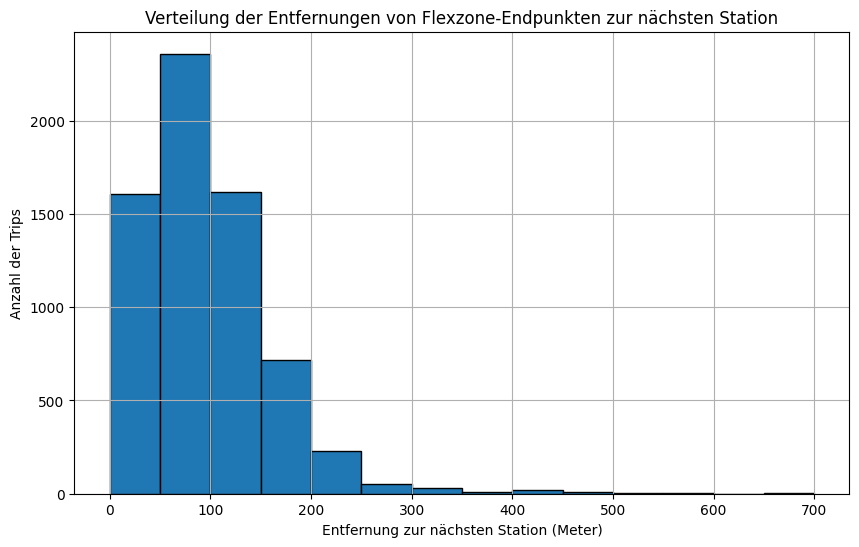

In [34]:
import pandas as pd
import numpy as np
import requests
from scipy.spatial import KDTree
import sys
import time
import matplotlib.pyplot as plt

# --- 1. Nextbike API für Berlin abrufen und Stationen mit bike: false extrahieren ---
API_URL = "https://api.nextbike.net/maps/nextbike-live.json?city=362"
response = requests.get(API_URL)
data = response.json()

stations_bike_false = []
for country in data.get('countries', []):
    for city in country.get('cities', []):
        if city.get('uid') == 362:
            for place in city.get('places', []):
                if place.get('spot', False) and place.get('bike', True) == False:
                    lat = place.get('lat')
                    lng = place.get('lng')
                    if lat is not None and lng is not None:
                        stations_bike_false.append((lat, lng))
print(f"Gefundene Stationen mit bike: false: {len(stations_bike_false)}")

# --- 2. Trip-CSV laden und bereinigen ---
trip_sheet = '/DATA/TripAnalysis/nextbike_trips.csv'

trip_df = (
    pd.read_csv(trip_sheet.lstrip('/'))
    .pipe(lambda d: d.rename(columns={c: c.strip() for c in d.columns}))
    .assign(**{
        'Duration-Minutes': lambda d: pd.to_numeric(d['Duration-Minutes'], errors='coerce'),
        'Rental-Lat': lambda d: pd.to_numeric(d['Rental-Lat'], errors='coerce'),
        'Rental-Lng': lambda d: pd.to_numeric(d['Rental-Lng'], errors='coerce'),
        'Return-Lat': lambda d: pd.to_numeric(d['Return-Lat'], errors='coerce'),
        'Return-Lng': lambda d: pd.to_numeric(d['Return-Lng'], errors='coerce'),
    })
    .loc[lambda d: ~d.apply(lambda r: r.astype(str).str.contains('unbekannt', case=False).any(), axis=1)]
    .loc[lambda d: d['Duration-Minutes'] > 2]
    .loc[lambda d: ~((d['Rental-Lat'] == d['Return-Lat']) & (d['Rental-Lng'] == d['Return-Lng']))]
    .reset_index(drop=True)
)
print(f"Trips loaded and cleaned: {len(trip_df)}")

# --- 3. Filter Trips mit Movement-Type, die auf ':Flexzone' enden ---
flexzone_trips = trip_df[trip_df['Movement-Type'].str.endswith(':Flexzone', na=False)].copy()
print(f"Trips ending in Flexzone: {len(flexzone_trips)}")

# --- 4. KDTree für schnelle Stationssuche vorbereiten ---
stations_np = np.array(stations_bike_false)
stations_tree = KDTree(stations_np[:, [1, 0]])  # KDTree mit (lng, lat)

# --- 5. Haversine-Funktion für exakte Distanz ---
def haversine_np(lon1, lat1, lon2, lat2):
    R = 6371000  # Erdradius in Metern
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# --- 6. Entfernung zur nächsten Station mit Fortschrittsanzeige berechnen ---
distances = []
total = len(flexzone_trips)
start_time = time.time()

for i, (_, row) in enumerate(flexzone_trips.iterrows(), 1):
    ret_lat = row['Return-Lat']
    ret_lng = row['Return-Lng']
    if pd.isna(ret_lat) or pd.isna(ret_lng):
        distances.append(np.nan)
        continue
    dist_kdtree, idxs = stations_tree.query([ret_lng, ret_lat], k=5)
    nearest_stations = stations_np[idxs]
    dists = haversine_np(ret_lng, ret_lat, nearest_stations[:, 1], nearest_stations[:, 0])
    distances.append(dists.min())
    if i % 100 == 0 or i == total:
        percent = (i / total) * 100
        elapsed = time.time() - start_time
        sys.stdout.write(f"\rBerechnung: {percent:.1f}% abgeschlossen, Zeit vergangen: {elapsed:.1f}s")
        sys.stdout.flush()
print("\nBerechnung abgeschlossen.")

flexzone_trips['dist_to_station_m'] = distances
valid_trips = flexzone_trips.dropna(subset=['dist_to_station_m'])
print(f"Anzahl Trips mit gültiger Distanz: {len(valid_trips)}")

for idx, row in valid_trips.head(10).iterrows():
    dist = row['dist_to_station_m']
    print(f"Bike-Number: {row['Bike-Number']}, Entfernung zur nächsten Station: {dist:,.0f} m")

# --- 7. Verteilung der Entfernungen visualisieren ---
distances = valid_trips['dist_to_station_m']
bins = np.arange(0, distances.max() + 50, 50)  # 50m Intervalle

plt.figure(figsize=(10,6))
plt.hist(distances, bins=bins, edgecolor='black')
plt.xlabel('Entfernung zur nächsten Station (Meter)')
plt.ylabel('Anzahl der Trips')
plt.title('Verteilung der Entfernungen von Flexzone-Endpunkten zur nächsten Station')
plt.grid(True)
plt.show()


Gefundene Stationen mit bike: false: 2571
Trips loaded and cleaned: 167799
Trips ending in Flexzone: 6654
Berechnung: 100.0% abgeschlossen, Zeit vergangen: 0.3s
Berechnung abgeschlossen.
Anzahl Trips mit gültiger Distanz: 6654
Bike-Number: 16641, Entfernung zur nächsten Station: 40 m
Bike-Number: 100501, Entfernung zur nächsten Station: 243 m
Bike-Number: 10636, Entfernung zur nächsten Station: 127 m
Bike-Number: 18783, Entfernung zur nächsten Station: 134 m
Bike-Number: 10703, Entfernung zur nächsten Station: 31 m
Bike-Number: 19982, Entfernung zur nächsten Station: 103 m
Bike-Number: 10626, Entfernung zur nächsten Station: 41 m
Bike-Number: 19667, Entfernung zur nächsten Station: 274 m
Bike-Number: 16319, Entfernung zur nächsten Station: 107 m
Bike-Number: 17316, Entfernung zur nächsten Station: 158 m


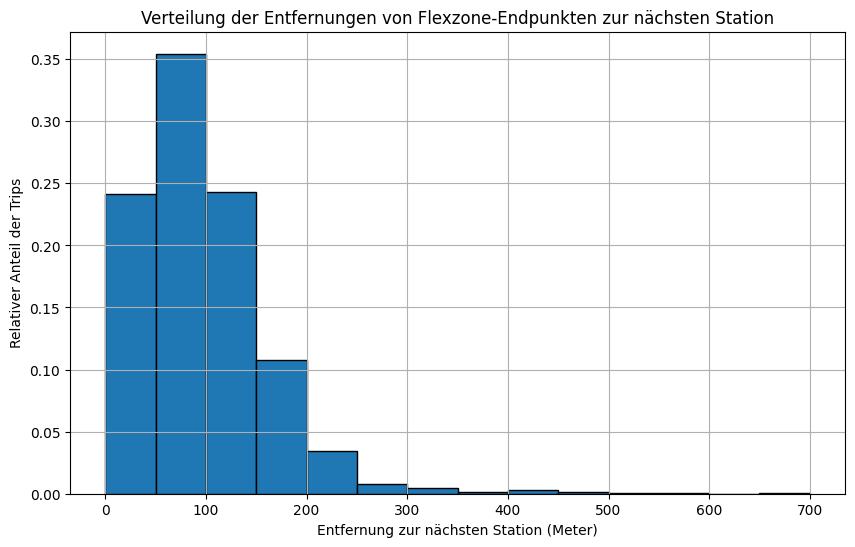

In [ ]:
import pandas as pd
import numpy as np
import requests
from scipy.spatial import KDTree
import sys
import time
import matplotlib.pyplot as plt

# --- 1. Nextbike API für Berlin abrufen und Stationen mit bike: false extrahieren ---
API_URL = "https://api.nextbike.net/maps/nextbike-live.json?city=362"
response = requests.get(API_URL)
data = response.json()

stations_bike_false = []
for country in data.get('countries', []):
    for city in country.get('cities', []):
        if city.get('uid') == 362:
            for place in city.get('places', []):
                if place.get('spot', False) and place.get('bike', True) == False:
                    lat = place.get('lat')
                    lng = place.get('lng')
                    if lat is not None and lng is not None:
                        stations_bike_false.append((lat, lng))
print(f"Gefundene Stationen mit bike: false: {len(stations_bike_false)}")

# --- 2. Trip-CSV laden und bereinigen ---
trip_sheet = '/DATA/TripAnalysis/nextbike_trips.csv'

trip_df = (
    pd.read_csv(trip_sheet.lstrip('/'))
    .pipe(lambda d: d.rename(columns={c: c.strip() for c in d.columns}))
    .assign(**{
        'Duration-Minutes': lambda d: pd.to_numeric(d['Duration-Minutes'], errors='coerce'),
        'Rental-Lat': lambda d: pd.to_numeric(d['Rental-Lat'], errors='coerce'),
        'Rental-Lng': lambda d: pd.to_numeric(d['Rental-Lng'], errors='coerce'),
        'Return-Lat': lambda d: pd.to_numeric(d['Return-Lat'], errors='coerce'),
        'Return-Lng': lambda d: pd.to_numeric(d['Return-Lng'], errors='coerce'),
    })
    .loc[lambda d: ~d.apply(lambda r: r.astype(str).str.contains('unbekannt', case=False).any(), axis=1)]
    .loc[lambda d: d['Duration-Minutes'] > 2]
    .loc[lambda d: ~((d['Rental-Lat'] == d['Return-Lat']) & (d['Rental-Lng'] == d['Return-Lng']))]
    .reset_index(drop=True)
)
print(f"Trips loaded and cleaned: {len(trip_df)}")

# --- 3. Filter Trips mit Movement-Type, die auf ':Flexzone' enden ---
flexzone_trips = trip_df[trip_df['Movement-Type'].str.endswith(':Flexzone', na=False)].copy()
print(f"Trips ending in Flexzone: {len(flexzone_trips)}")

# --- 4. KDTree für schnelle Stationssuche vorbereiten ---
stations_np = np.array(stations_bike_false)
stations_tree = KDTree(stations_np[:, [1, 0]])  # KDTree mit (lng, lat)

# --- 5. Haversine-Funktion für exakte Distanz ---
def haversine_np(lon1, lat1, lon2, lat2):
    R = 6371000  # Erdradius in Metern
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# --- 6. Entfernung zur nächsten Station mit Fortschrittsanzeige berechnen ---
distances = []
total = len(flexzone_trips)
start_time = time.time()

for i, (_, row) in enumerate(flexzone_trips.iterrows(), 1):
    ret_lat = row['Return-Lat']
    ret_lng = row['Return-Lng']
    if pd.isna(ret_lat) or pd.isna(ret_lng):
        distances.append(np.nan)
        continue

    dist_kdtree, idxs = stations_tree.query([ret_lng, ret_lat], k=5)
    nearest_stations = stations_np[idxs]
    dists = haversine_np(ret_lng, ret_lat, nearest_stations[:, 1], nearest_stations[:, 0])
    distances.append(dists.min())

    if i % 100 == 0 or i == total:
        percent = (i / total) * 100
        elapsed = time.time() - start_time
        sys.stdout.write(f"\rBerechnung: {percent:.1f}% abgeschlossen, Zeit vergangen: {elapsed:.1f}s")
        sys.stdout.flush()

print("\nBerechnung abgeschlossen.")

flexzone_trips['dist_to_station_m'] = distances
valid_trips = flexzone_trips.dropna(subset=['dist_to_station_m'])
print(f"Anzahl Trips mit gültiger Distanz: {len(valid_trips)}")

for idx, row in valid_trips.head(10).iterrows():
    dist = row['dist_to_station_m']
    print(f"Bike-Number: {row['Bike-Number']}, Entfernung zur nächsten Station: {dist:,.0f} m")

# --- 7. Verteilung der Entfernungen visualisieren (Y-Achse: Relativer Anteil) ---
distances = valid_trips['dist_to_station_m']
bins = np.arange(0, distances.max() + 50, 50)  # 50m Intervalle

# Relative Häufigkeiten berechnen und als Balken plotten
hist, bin_edges = np.histogram(distances, bins=bins)
hist_rel = hist / hist.sum()

plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], hist_rel, width=50, align='edge', edgecolor='black')
plt.xlabel('Entfernung zur nächsten Station (Meter)')
plt.ylabel('Relativer Anteil der Trips')
# plt.title('Verteilung der Entfernungen von Flexzone-Endpunkten zur nächsten Station')
plt.grid(True)
plt.show()


In [35]:
import pandas as pd
import numpy as np
import requests
from scipy.spatial import KDTree
import sys
import time
import matplotlib.pyplot as plt

# --- 1. Fetch bike stations with bike=False from the API ---
API_URL = "https://api.nextbike.net/maps/nextbike-live.json?city=362"
response = requests.get(API_URL)
data = response.json()

stations_bike_false = []
for country in data.get('countries', []):
    for city in country.get('cities', []):
        if city.get('uid') == 362:
            for place in city.get('places', []):
                if place.get('spot', False) and place.get('bike', False) == False:
                    lat = place.get('lat')
                    lng = place.get('lng')
                    if lat is not None and lng is not None:
                        stations_bike_false.append((lat, lng))
print(f"Found {len(stations_bike_false)} stations with bike=False")

# --- 2. Load and clean trip data ---
trip_file = '/DATA/TripAnalysis/nextbike.csv'  # Use your actual path here
trip_df = (
    pd.read_csv(trip_file)
    .pipe(lambda df: df.rename(columns=lambda x: x.strip()))
    .assign(
        Duration_Minutes=lambda df: pd.to_numeric(df['Duration-Minutes'], errors='coerce'),
        Rental_Lat=lambda df: pd.to_numeric(df['Rental-Lat'], errors='coerce'),
        Rental_Lng=lambda df: pd.to_numeric(df['Rental-Lng'], errors='coerce'),
        Return_Lat=lambda df: pd.to_numeric(df['Return-Lat'], errors='coerce'),
        Return_Lng=lambda df: pd.to_numeric(df['Return-Lng'], errors='coerce'),
    )
    .loc[lambda df: ~df.apply(lambda row: row.astype(str).str.contains('unknown', case=False).any(), axis=1)]
    .loc[lambda df: df['Duration_Minutes'] > 2]
    .loc[lambda df: ~((df['Rental_Lat'] == df['Return_Lat']) & (df['Rental_Lng'] == df['Return_Lng']))]
    .reset_index(drop=True)
)
print(f"Trips loaded and cleaned: {len(trip_df)}")

# --- 3. Filter trips ending in flexzone ---
flexzone_trips = trip_df[trip_df['Movement-Type'].str.endswith(':Flexzone', na=False)].copy()
print(f"Trips ending in Flexzone: {len(flexzone_trips)}")

# --- 4. Prepare KDTree for fast nearest station search ---
stations_np = np.array(stations_bike_false)
stations_tree = KDTree(stations_np[:, [1, 0]])  # KDTree expects (lng, lat)

# --- 5. Haversine formula for accurate distances ---
def haversine_np(lon1, lat1, lon2, lat2):
    R = 6371000  # Earth radius in meters
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# --- 6. Calculate distance to nearest station with progress ---
distances = []
total = len(flexzone_trips)
start_time = time.time()

for i, row in flexzone_trips.iterrows():
    ret_lat = row['Return_Lat']
    ret_lng = row['Return_Lng']
    if pd.isna(ret_lat) or pd.isna(ret_lng):
        distances.append(np.nan)
        continue
    dist_kdtree, idxs = stations_tree.query([ret_lng, ret_lat], k=5)
    nearest_stations = stations_np[idxs]
    dists = haversine_np(ret_lng, ret_lat, nearest_stations[:, 1], nearest_stations[:, 0])
    distances.append(dists.min())
    if (i + 1) % 100 == 0 or (i + 1) == total:
        print(f"\rProgress: {(i + 1) / total * 100:.1f}% completed, elapsed time: {time.time() - start_time:.2f}s", end='')

print("\nCalculation completed.")

flexzone_trips['dist_to_station_m'] = distances

# --- 7. Plot relative distribution ---
distances = flexzone_trips['dist_to_station_m'].dropna()
bins = np.arange(0, distances.max() + 50, 50)  # 50 meter bins

plt.figure(figsize=(10,6))
plt.hist(distances, bins=bins, density=True, edgecolor='black', alpha=0.7)  # density=True for relative frequency
plt.xlabel('Distance to nearest station (meters)')
plt.ylabel('Relative frequency')
plt.title('Relative distribution of distances for trips ending in Flexzone')
plt.grid(True)
plt.show()


Found 2571 stations with bike=False


FileNotFoundError: [Errno 2] No such file or directory: '/DATA/TripAnalysis/nextbike.csv'

Gefundene Stationen mit bike: false: 2630
Loaded 16 Flexzone Polygone (c0)
Trips loaded and cleaned: 167799
Trips ending in NoFlexzone: 1506
Berechnung: 100.0% abgeschlossen, Zeit vergangen: 0.8s
Berechnung abgeschlossen.
Anzahl Trips mit gültiger Distanz: 1506
Bike-Number: 17409, Entfernung zur nächsten Station: 51 m, Entfernung zur nächsten Flexzone: 33 m
Bike-Number: 15272, Entfernung zur nächsten Station: 57 m, Entfernung zur nächsten Flexzone: 75 m
Bike-Number: 15580, Entfernung zur nächsten Station: 66 m, Entfernung zur nächsten Flexzone: 11 m
Bike-Number: 15643, Entfernung zur nächsten Station: 153 m, Entfernung zur nächsten Flexzone: 79 m
Bike-Number: 10272, Entfernung zur nächsten Station: 69 m, Entfernung zur nächsten Flexzone: 2 m
Bike-Number: 16053, Entfernung zur nächsten Station: 79 m, Entfernung zur nächsten Flexzone: 334 m
Bike-Number: 13582, Entfernung zur nächsten Station: 176 m, Entfernung zur nächsten Flexzone: 244 m
Bike-Number: 16138, Entfernung zur nächsten Stati

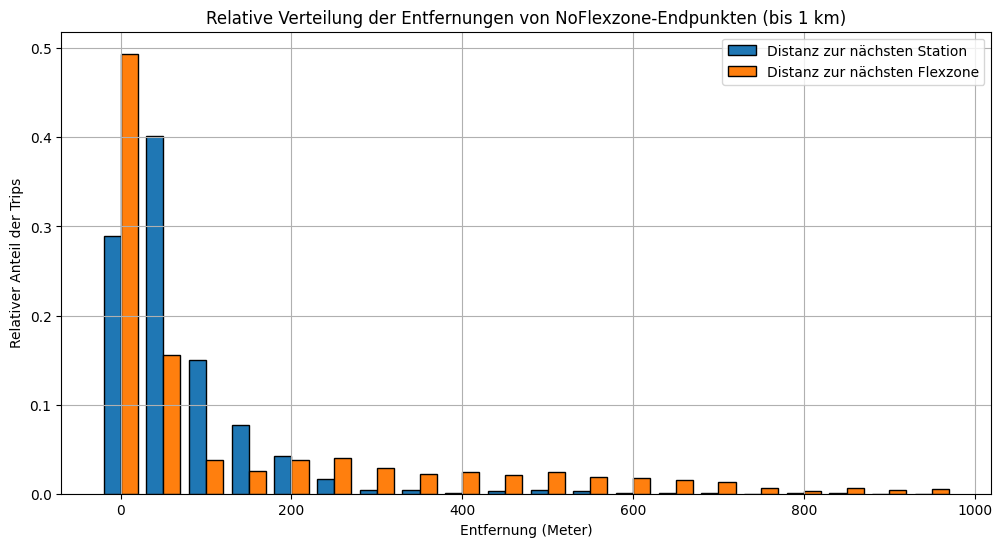

In [ ]:
import pandas as pd
import numpy as np
import requests
from scipy.spatial import KDTree
import sys
import time
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

# --- 1. Nextbike API für Berlin abrufen und Stationen mit bike: false extrahieren ---

API_URL = "https://api.nextbike.net/maps/nextbike-live.json?city=362"
response = requests.get(API_URL)
data = response.json()

stations_bike_false = []
for country in data.get('countries', []):
    for city in country.get('cities', []):
        if city.get('uid') == 362:
            for place in city.get('places', []):
                if place.get('spot', False) and place.get('bike', True) == False:
                    lat = place.get('lat')
                    lng = place.get('lng')
                    if lat is not None and lng is not None:
                        stations_bike_false.append((lat, lng))

print(f"Gefundene Stationen mit bike: false: {len(stations_bike_false)}")

# --- 2. Flexzonen (c0) aus GeoJSON laden ---

flexzone_url = "https://api.nextbike.net/reservation/geojson/flexzone_bn.json"
response = requests.get(flexzone_url)
flex_data = response.json()

flex_polygons_c0 = []
for feature in flex_data.get('features', []):
    if feature['geometry']['type'] == 'Polygon':
        coords = feature['geometry']['coordinates'][0]
        poly = Polygon([(c[0], c[1]) for c in coords])
        flex_polygons_c0.append(poly)

print(f"Loaded {len(flex_polygons_c0)} Flexzone Polygone (c0)")

# --- 3. Trip-CSV laden und bereinigen ---

trip_sheet = '/DATA/TripAnalysis/nextbike_trips.csv'

trip_df = (
    pd.read_csv(trip_sheet.lstrip('/'))
    .pipe(lambda d: d.rename(columns={c: c.strip() for c in d.columns}))
    .assign(**{
        'Duration-Minutes': lambda d: pd.to_numeric(d['Duration-Minutes'], errors='coerce'),
        'Rental-Lat': lambda d: pd.to_numeric(d['Rental-Lat'], errors='coerce'),
        'Rental-Lng': lambda d: pd.to_numeric(d['Rental-Lng'], errors='coerce'),
        'Return-Lat': lambda d: pd.to_numeric(d['Return-Lat'], errors='coerce'),
        'Return-Lng': lambda d: pd.to_numeric(d['Return-Lng'], errors='coerce'),
    })
    .loc[lambda d: ~d.apply(lambda r: r.astype(str).str.contains('unbekannt', case=False).any(), axis=1)]
    .loc[lambda d: d['Duration-Minutes'] > 2]
    .loc[lambda d: ~((d['Rental-Lat'] == d['Return-Lat']) & (d['Rental-Lng'] == d['Return-Lng']))]
    .reset_index(drop=True)
)

print(f"Trips loaded and cleaned: {len(trip_df)}")

# --- 4. Filter Trips mit Movement-Type, die auf ':NoFlexzone' enden ---

noflexzone_trips = trip_df[trip_df['Movement-Type'].str.endswith(':NoFlexzone', na=False)].copy()
print(f"Trips ending in NoFlexzone: {len(noflexzone_trips)}")

# --- 5. KDTree für schnelle Stationssuche vorbereiten ---

stations_np = np.array(stations_bike_false)
stations_tree = KDTree(stations_np[:, [1, 0]])  # KDTree mit (lng, lat)

# --- 6. Haversine-Funktion für exakte Distanz ---

def haversine_np(lon1, lat1, lon2, lat2):
    R = 6371000  # Erdradius in Metern
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# --- 7. Funktion zur Distanz zur nächsten Flexzone (Polygon c0) ---

def distance_to_nearest_flexzone(lat, lng, polygons):
    point = Point(lng, lat)
    min_dist = float('inf')
    for poly in polygons:
        nearest_point = poly.exterior.interpolate(poly.exterior.project(point))
        dist_m = haversine_np(lng, lat, nearest_point.x, nearest_point.y)
        if dist_m < min_dist:
            min_dist = dist_m
    return min_dist

# --- 8. Entfernung zur nächsten Station und Flexzone berechnen mit Fortschrittsanzeige ---

dist_to_station = []
dist_to_flexzone = []
total = len(noflexzone_trips)
start_time = time.time()

for i, (_, row) in enumerate(noflexzone_trips.iterrows(), 1):
    ret_lat = row['Return-Lat']
    ret_lng = row['Return-Lng']

    if pd.isna(ret_lat) or pd.isna(ret_lng):
        dist_to_station.append(np.nan)
        dist_to_flexzone.append(np.nan)
        continue

    # Nächste Station
    dist_kdtree, idxs = stations_tree.query([ret_lng, ret_lat], k=5)
    nearest_stations = stations_np[idxs]
    dists_station = haversine_np(ret_lng, ret_lat, nearest_stations[:, 1], nearest_stations[:, 0])
    dist_to_station.append(dists_station.min())

    # Nächste Flexzone
    dist_flex = distance_to_nearest_flexzone(ret_lat, ret_lng, flex_polygons_c0)
    dist_to_flexzone.append(dist_flex)

    if i % 100 == 0 or i == total:
        percent = (i / total) * 100
        elapsed = time.time() - start_time
        sys.stdout.write(f"\rBerechnung: {percent:.1f}% abgeschlossen, Zeit vergangen: {elapsed:.1f}s")
        sys.stdout.flush()

print("\nBerechnung abgeschlossen.")

noflexzone_trips['dist_to_station_m'] = dist_to_station
noflexzone_trips['dist_to_flexzone_m'] = dist_to_flexzone

# --- 9. Ausgabe der ersten Ergebnisse ---

valid_trips = noflexzone_trips.dropna(subset=['dist_to_station_m', 'dist_to_flexzone_m'])
print(f"Anzahl Trips mit gültiger Distanz: {len(valid_trips)}")

for idx, row in valid_trips.head(10).iterrows():
    print(f"Bike-Number: {row['Bike-Number']}, Entfernung zur nächsten Station: {row['dist_to_station_m']:,.0f} m, "
          f"Entfernung zur nächsten Flexzone: {row['dist_to_flexzone_m']:,.0f} m")

# --- 10. Verteilung der Entfernungen als gruppiertes Balkendiagramm visualisieren ---

dist_station = valid_trips['dist_to_station_m']
dist_flex = valid_trips['dist_to_flexzone_m']

max_dist = 1000
bins = np.arange(0, max_dist + 50, 50)  # 50m Intervalle

hist_station, _ = np.histogram(dist_station[dist_station <= max_dist], bins=bins)
hist_flex, _ = np.histogram(dist_flex[dist_flex <= max_dist], bins=bins)

# Balkenbreite und Positionen für gruppiertes Balkendiagramm
width = 20
positions = bins[:-1]

plt.figure(figsize=(12,6))
plt.bar(positions - width/2, hist_station / hist_station.sum(), width=width, label='Distanz zur nächsten Station', edgecolor='black')
plt.bar(positions + width/2, hist_flex / hist_flex.sum(), width=width, label='Distanz zur nächsten Flexzone', edgecolor='black')

plt.xlabel('Entfernung (Meter)')
plt.ylabel('Relativer Anteil der Trips')
plt.title('Relative Verteilung der Entfernungen von NoFlexzone-Endpunkten (bis 1 km)')
plt.legend()
plt.grid(True)
plt.show()
